In [1]:
!echo "Last updated:" `date`

Last updated: Fri Jul 24 12:04:14 PDT 2020


# Fitting regular GP in STAN

This notebook demonstrates how a GP is specified and sampled from in STAN.

In [2]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../util')
from pystan_vb_extract import pystan_vb_extract
import gp_plot_util
import copy

In [3]:
# Define GP model.

# See for an explaination of the parameters (rho, alpha) and the convariance function used.
# https://mc-stan.org/docs/2_19/stan-users-guide/gaussian-process-regression.html

gp_model_code = """
data {
    int D;               // number of features (dimensions of X)
    int N;               // number of observations
    vector[N] y;         // response
    matrix[N, D] X;      // predictors
    real<lower=0> eps;   // amount to add to diagonal of covariance function (for numerical stability)
    
    // hyperparameters for GP covariance function range and scale.
    real m_rho;
    real<lower=0> s_rho;
    real m_alpha;
    real<lower=0> s_alpha;
}

transformed data {
    // GP mean function.
    vector[N] mu = rep_vector(0, N);
}

parameters {
    real<lower=0> rho;   // range parameter in GP covariance fn
    real<lower=0> alpha; // covariance scale parameter in GP covariance fn
}

model {
    matrix[N, N] K;   // GP covariance matrix
    matrix[N, N] LK;  // cholesky of GP covariance matrix

    rho ~ lognormal(m_rho, s_rho);  // GP covariance function range parameter
    alpha ~ lognormal(m_alpha, s_alpha);  // GP covariance function scale parameter
   
    // Using exponential quadratic covariance function
    // K(d) = alpha^2 * exp(-0.5 * (d/rho)^2)
    K = cov_exp_quad(to_array_1d(X), alpha, rho); 
    
    // Add small values along diagonal elements for numerical stability.
    for (n in 1:N) {
        K[n, n] = K[n, n] + eps;
    }
        
    // Cholesky of K (lower triangle).
    LK = cholesky_decompose(K);

    // GP likelihood.
    y ~ multi_normal_cholesky(mu, LK);
}
"""

In [4]:
%%time
# Compile model. This takes about a minute.
sm = pystan.StanModel(model_code=gp_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eda81164fce2d216564d967cdfdadbc5 NOW.


CPU times: user 809 ms, sys: 64.1 ms, total: 873 ms
Wall time: 51 s


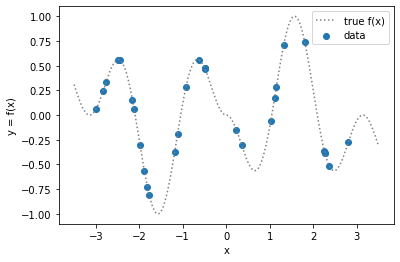

In [5]:
# Read data.
path_to_data = '../data/gp-data-N30.json'
simdata = json.load(open(path_to_data))

# Plot data and true function.
plt.scatter(simdata['x'], simdata['f'], label='data')
plt.plot(simdata['x_true'], simdata['f_true'], ls=':', c='grey', label='true f(x)')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend();

In [6]:
# Data dictionary.
N = len(simdata['x'])
data = dict(y=simdata['f'], X=np.reshape(simdata['x'], (N, 1)), N=N, D=1,
            eps=1e-3, m_rho=-2, s_rho=0.1, m_alpha=0, s_alpha=1)

In [7]:
%%time
# Fit via ADVI.
vb_fit = sm.vb(data=data, iter=2000, seed=2)
vb_samples = pystan_vb_extract(vb_fit)

CPU times: user 157 ms, sys: 289 µs, total: 157 ms
Wall time: 156 ms


In [8]:
%%time
# Fit via HMC
hmc_fit = sm.sampling(data=data, iter=2000, chains=1, warmup=1000, thin=1,
                      seed=1, algorithm='HMC', control=dict(stepsize=0.01, int_time=1))

CPU times: user 1.46 s, sys: 4.51 ms, total: 1.46 s
Wall time: 1.46 s


In [9]:
%%time
# Fit via NUTS
nuts_fit = sm.sampling(data=data, iter=2000, chains=1, warmup=1000, thin=1, seed=1)

CPU times: user 587 ms, sys: 0 ns, total: 587 ms
Wall time: 585 ms


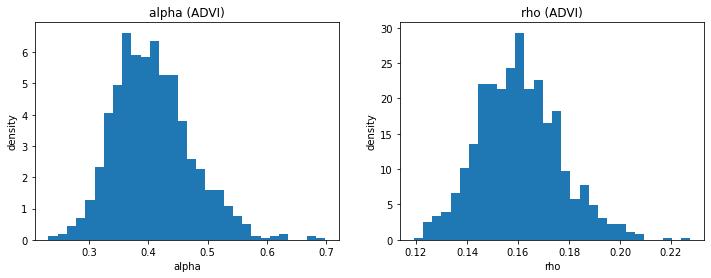

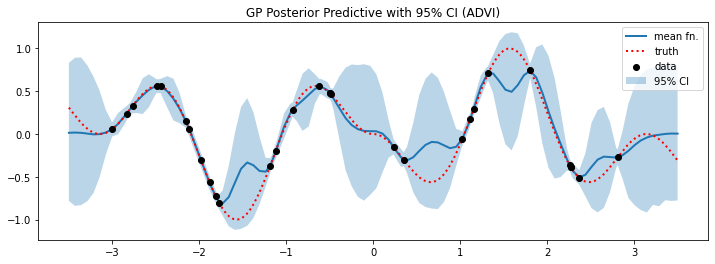

In [10]:
gp_plot_util.make_plots(vb_samples, suffix="ADVI",
                        x=np.array(simdata['x']), y=np.array(simdata['f']),
                        x_true=simdata['x_true'], f_true=simdata['f_true'])

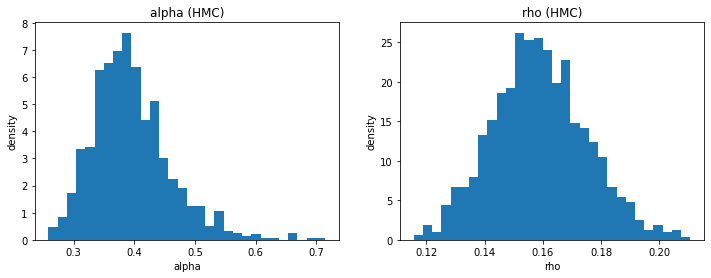

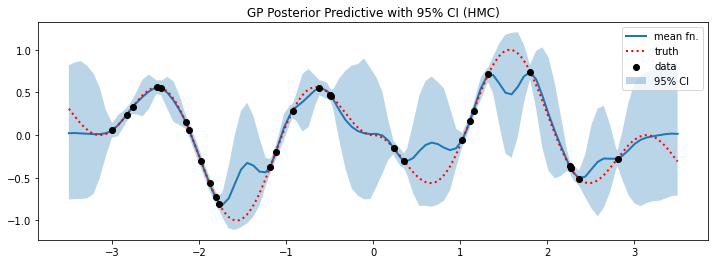

In [13]:
gp_plot_util.make_plots(hmc_fit, suffix="HMC",
                        x=np.array(simdata['x']), y=np.array(simdata['f']),
                        x_true=simdata['x_true'], f_true=simdata['f_true'])

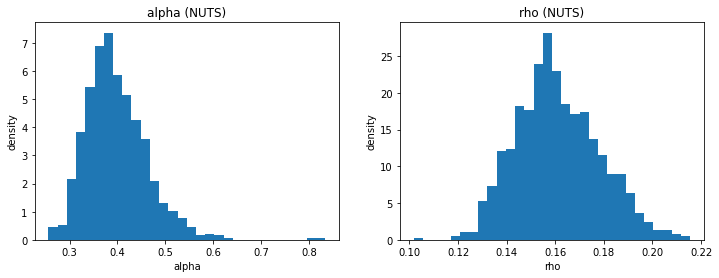

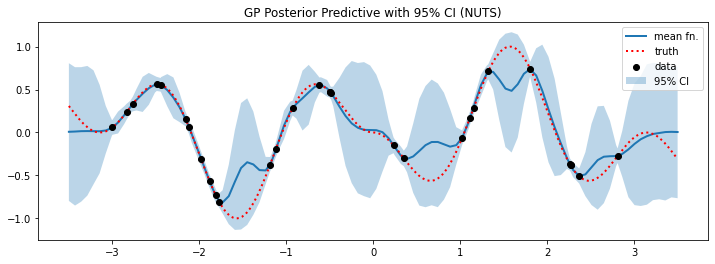

In [18]:
gp_plot_util.make_plots(nuts_fit, suffix="NUTS",
                        x=np.array(simdata['x']), y=np.array(simdata['f']),
                        x_true=simdata['x_true'], f_true=simdata['f_true'])